In [210]:
import pandas as pd
from sklearn.metrics import brier_score_loss


In [211]:
tourney_results = pd.read_csv("../data/MNCAATourneyDetailedResults.csv")
tourney_results = tourney_results
t1 = tourney_results[["Season", "WTeamID", "LTeamID"]].copy()
t1.columns = ["Season", "Team1", "Team2"]
t2 = tourney_results[["Season", "LTeamID", "WTeamID"]].copy() 
t2.columns = ["Season", "Team1", "Team2"]
t1["Outcome"] = 1
t2["Outcome"] = 0
ground_truth = pd.concat([t1,t2], axis=0)
ground_truth["ID"] = ground_truth.Season.astype(str) + "_" + ground_truth["Team1"].astype(str) + "_" +ground_truth["Team2"].astype(str)


In [212]:
# import numpy as np
# ground_truth["ID"] = np.where(ground_truth["Team1"] < ground_truth["Team2"],
#                     ground_truth["Season"].astype(str) + '_' + ground_truth["Team1"].astype(str) + '_' + ground_truth["Team2"].astype(str),
#                     ground_truth["Season"].astype(str) + '_' + ground_truth["Team2"].astype(str) + '_' + ground_truth["Team1"].astype(str))

In [213]:
ground_truth = ground_truth[ground_truth.Season >= 2010]



In [214]:
sky_preds = pd.read_csv("../submissions/all_sky_model_preds.csv")
old_sky = pd.read_csv("../submissions/all_sky_model_preds_old.csv")
raddar_preds = pd.read_csv("../submissions/all_raddar_preds.csv")

raddar_preds[['Season', 'Team1', 'Team2']] = raddar_preds.ID.str.split('_', expand=True)
old_sky[['Season', 'Team1', 'Team2']] = raddar_preds.ID.str.split('_', expand=True)
sky_preds[['Season', 'Team1', 'Team2']] = sky_preds.ID.str.split('_', expand=True)


In [215]:
ground_truth = ground_truth.merge(raddar_preds.rename(columns={"Pred": "raddar_pred"})[["ID", "raddar_pred"]],
                   how = "inner", 
                   on = "ID")

ground_truth = ground_truth.merge(sky_preds.rename(columns={"Pred": "sky_pred"})[["ID", "sky_pred"]],
                   how = "inner", 
                   on = "ID")

ground_truth = ground_truth.merge(old_sky.rename(columns={"Pred": "old_sky"})[["ID", "old_sky"]],
                   how = "inner", 
                   on = "ID")

In [217]:
### Loop through seasons and score

data = []

for s in ground_truth.Season.unique():

    tmp = ground_truth[ground_truth.Season == s].copy()

    raddar_loss = brier_score_loss(tmp.Outcome, tmp.raddar_pred)
    sky_loss_loss = brier_score_loss(tmp.Outcome, tmp.sky_pred)
    old_sky_loss = brier_score_loss(tmp.Outcome, tmp.old_sky)
    
    
    data.append([s, raddar_loss, sky_loss_loss, old_sky_loss])



In [218]:
raddar_vs_sky_by_year = pd.DataFrame(data, columns = ["Season", "raddar_loss", "sky_loss", "old_sky_loss"])

In [220]:
raddar_vs_sky_by_year.mean()

Season          2016.230769
raddar_loss        0.199605
sky_loss           0.190490
old_sky_loss       0.191827
dtype: float64

In [204]:
import numpy as np
raddar_vs_sky_by_year["sky_better"] = np.where(raddar_vs_sky_by_year.sky_loss < raddar_vs_sky_by_year.raddar_loss, 1, 0)

In [207]:
raddar_vs_sky_by_year

,Season,raddar_loss,sky_loss,sky_better
0,2010,0.198824,0.193138,1
1,2011,0.217906,0.229749,0
2,2012,0.190189,0.176470,1
3,2013,0.211128,0.196362,1
4,2014,0.215891,0.193110,1
5,2015,0.161901,0.154845,1
6,2016,0.206264,0.176012,1
7,2017,0.159481,0.154268,1
8,2018,0.205780,0.203107,1
9,2019,0.180438,0.160533,1


In [205]:
data = []

for i in range(1,101):    
    i = i/100
    ground_truth["blend"] = ground_truth["sky_pred"] * i + ground_truth["raddar_pred"] * (1-i) 
    loss = brier_score_loss(ground_truth.Outcome, ground_truth.blend)
    data.append([i, 1-i, loss])



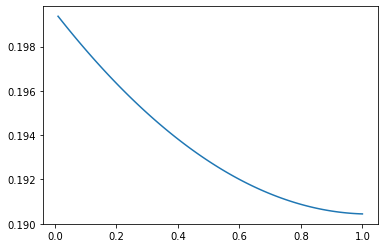

In [206]:
tmp = pd.DataFrame(data, columns = ["percent_sky", "percent_raddar", "loss"])
tmp.sort_values(by = "percent_sky", inplace=True)

import matplotlib.pyplot as plt

plt.plot(tmp.percent_sky, tmp.loss)

Doesn't look like raddar preds help for most years.
Except last year, which makes me nervous that I'm not tuning the raddar approach in previous years appropriately

In [110]:
raddar_preds = pd.read_csv("../submissions/raddar_2023.csv")
current_preds = pd.read_csv("../submissions/sub_2023_in_2024.csv")

In [111]:
current_preds.columns = ["old_index", "ID", "current_preds"]
raddar_preds = raddar_preds[["ID", "Pred"]]
raddar_preds.columns = ["ID", "raddar_preds"]

In [112]:
combined = current_preds.merge(raddar_preds, how="left", on="ID")

In [113]:
combined = combined.merge(ground_truth, how = "left", on = "ID")

In [114]:
combined = combined[combined.Outcome.notnull()]

In [115]:
from sklearn.metrics import brier_score_loss

brier_score_loss(combined.Outcome, combined.raddar_preds)


0.20070122045159614

In [116]:
brier_score_loss(combined.Outcome, combined.current_preds)

0.21835883109568746